<a href="https://colab.research.google.com/github/Kanakbaghel/Capstone_Project/blob/main/Scripts/P1%20%3A%20Data%20Cleaning%20and%20Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font size=8 color=steelblue >**Phase 1: Understanding RetailSmart’s Customer and Sales Behavior through Data Cleaning and Exploration**
------------------
-----------------


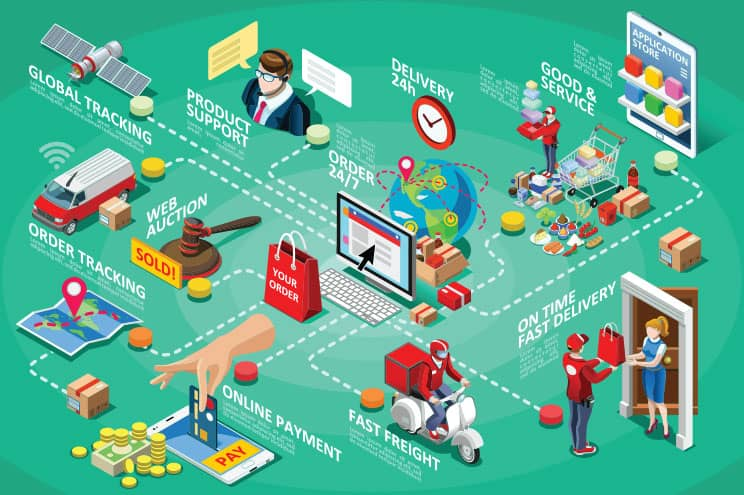

<font size=5 color=lightseagreen >**Business Context**

RetailSmart Analytics Pvt. Ltd. is a mid-sized e-commerce retailer that sells products across multiple
categories in both online and offline channels.
The company’s leadership suspects that **declining repeat purchases and uneven sales performance**
are linked to **data quality issues** and **limited visibility** into customer behavior.
They have provided you with five interconnected datasets derived from the company’s operational
databases (customers, products, sales, marketing, and reviews).


Now Let's shift to Google Colab for : **cleaning and exploring the data**.

This notebook will guide you step-by-step through loading your raw CSVs, handling nulls and outliers, standardizing everything and diving into EDA. We'll keep it detailed, clear, and honest. By the end, we'll export 5 cleaned CSVs ready for Phase 2.

Datasets Used

| Dataset  | Description | Key Columns |
|----------|----------------|-------------|
|customers.csv | Customer profiles and derived churn flag | customer_id, city state, total_orders, total_spent, days_since_last_order, churn_flag |
|sales.csv| Transaction-level data (joined from orders, items, payments)  |order_id, customer_id, product_id, category_english, price, payment_type,order_purchase_timestamp, total_price |
|products.csv| Product attributes | product_id, category_english, product_name_lenght, product_description_lenght, product_photos_qty |
| marketing.csv | Marketing campaign info | campaign_id, customer_id, channel, spend, conversions, response_rate |
| reviews.csv | Customer review text and scores |review_id, customer_id,review_score, review_comment_message |

> <font color=slateblue size=5>**Import Libraries**
-----

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style for pretty visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(f"\n Libraries imported successfully!")


 Libraries imported successfully!


> <font color=slateblue size=5>**Load the Cleaned Datasets**
-----
Loading five raw CSV files (Datasets)

In [2]:
# Load the Raw data CSV files with dtypes

customers = pd.read_csv('/content/customers.csv', dtype={'customer_id': str, 'churn_flag': int})
products = pd.read_csv('/content/products.csv', dtype={'product_id': str})
sales = pd.read_csv('/content/sales.csv', dtype={'order_id': str, 'customer_id': str, 'product_id': str})
marketing = pd.read_csv('/content/marketing.csv', dtype={'campaign_id': str, 'customer_id': str})
reviews = pd.read_csv('/content/reviews.csv', dtype={'review_id': str, 'order_id': str, 'customer_id': str})

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [3]:
# Quick peek at shapes to confirm
print("Here you go with the shapes of the datasets :-")

print(f"Customers: {customers.shape} rows")
print(f"Products: {products.shape} rows")
print(f"Sales: {sales.shape} rows")
print(f"Marketing: {marketing.shape} rows")
print(f"Reviews: {reviews.shape} rows")

Here you go with the shapes of the datasets :-
Customers: (99441, 11) rows
Products: (32951, 5) rows
Sales: (117604, 11) rows
Marketing: (510, 7) rows
Reviews: (40977, 5) rows


> <font color=slateblue size=5>**Initial Data Inspection**
-----
Before cleaning, let's get a feel for the data.

We'll check dtypes, nulls, and a sample.

In [4]:
# Collect info of all datasets
datasets = {
    "Customers": customers,
    "Marketing": marketing,
    "Products": products,
    "Reviews": reviews,
    "Sales": sales
}

for name, df in datasets.items():
    print(f"\n--- {name} Dataset Info ---")
    df.info()


--- Customers Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_unique_id        99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  int64  
 3   customer_city             99441 non-null  object 
 4   customer_state            99441 non-null  object 
 5   total_orders              98666 non-null  float64
 6   total_spent               98666 non-null  float64
 7   last_order                98666 non-null  object 
 8   days_since_last_order     93717 non-null  float64
 9   churn_flag                99441 non-null  int64  
 10  city                      0 non-null      float64
dtypes: float64(4), int64(2), object(5)
memory usage: 8.3+ MB

--- Marketing Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In [5]:
# let's check null values
for name, df in datasets.items():
    print(f"\n=== {name} Dataset ===")
    print("Total Rows:", len(df))
    print("Null values per column:\n", df.isnull().sum())
    print("=" * 50)


=== Customers Dataset ===
Total Rows: 99441
Null values per column:
 customer_id                     0
customer_unique_id              0
customer_zip_code_prefix        0
customer_city                   0
customer_state                  0
total_orders                  775
total_spent                   775
last_order                    775
days_since_last_order        5724
churn_flag                      0
city                        99441
dtype: int64

=== Marketing Dataset ===
Total Rows: 510
Null values per column:
 campaign_id      0
customer_id      0
channel          0
start_date       0
spend            0
conversions      0
response_rate    0
dtype: int64

=== Products Dataset ===
Total Rows: 32951
Null values per column:
 product_id                      0
category_english              618
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
dtype: int64

=== Reviews Dataset ===
Total Rows: 40977
Null values per column:
 review_id

## <font color=royalblue size=7>**B. Data Cleaning**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


> <font color=slateblue size=5>**Handle Missing Values**
-----
Nulls are lurking, let's tackle them! We'll impute smartly: medians for numbers, 'unknown' for cats. This preserves data without dropping rows.

**1. Handle missing values in category_english, payment_type, review_score, and
days_since_last_order.**

----------------------------------------------

In [6]:
# customers
customers.drop('city', axis=1, inplace=True)  # Drop the all-null 'city' column—it's junk!
customers.rename(columns={'customer_city': 'city', 'customer_state': 'state'}, inplace=True)
customers['total_orders'] = customers['total_orders'].fillna(0)  # No orders? Assume 0.
customers['total_spent'] = customers['total_spent'].fillna(0)
customers['last_order'] = customers['last_order'].fillna('unknown')
customers['days_since_last_order'] = customers['days_since_last_order'].fillna(customers['days_since_last_order'].median())

In [7]:
# Products
products['category_english'] = products['category_english'].fillna('unknown')
products['product_name_lenght'] = products['product_name_lenght'].fillna(products['product_name_lenght'].median())
products['product_description_lenght'] = products['product_description_lenght'].fillna(products['product_description_lenght'].median())
products['product_photos_qty'] = products['product_photos_qty'].fillna(products['product_photos_qty'].median())

In [8]:
# Sales
sales['category_english'] = sales['category_english'].fillna('unknown')
sales['payment_type'] = sales['payment_type'].fillna('unknown')
sales['payment_value'] = sales['payment_value'].fillna(sales['payment_value'].median())
sales['order_delivered_customer_date'] = sales['order_delivered_customer_date'].fillna(pd.NaT)  # NaT for missing dates

In [9]:
# Reviews
reviews['review_comment_message'] = reviews['review_comment_message'].fillna('')

In [10]:
# Marketing: Looks clean from SQL checks—no changes needed.

print("Nulls handled! Let's check:")

datasets = {
    "Customers": customers,
    "Marketing": marketing,
    "Products": products,
    "Reviews": reviews,
    "Sales": sales
}

for name, df in datasets.items():
    print(f"\n--- {name} Dataset Null Check ---")
    print(df.isnull().sum())

Nulls handled! Let's check:

--- Customers Dataset Null Check ---
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
city                        0
state                       0
total_orders                0
total_spent                 0
last_order                  0
days_since_last_order       0
churn_flag                  0
dtype: int64

--- Marketing Dataset Null Check ---
campaign_id      0
customer_id      0
channel          0
start_date       0
spend            0
conversions      0
response_rate    0
dtype: int64

--- Products Dataset Null Check ---
product_id                    0
category_english              0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
dtype: int64

--- Reviews Dataset Null Check ---
review_id                 0
order_id                  0
customer_id               0
review_score              0
review_comment_message    0
dtype: int64

--- Sales Dataset Null Check ---
orde

In [11]:
# Checking sales null values
null_delivery_dates = sales[sales['order_delivered_customer_date'].isnull()]
null_delivery_dates

,order_id,customer_id,product_id,category_english,price,freight_value,payment_type,payment_value,order_purchase_timestamp,order_delivered_customer_date,total_price
80,002f19a65a2ddd70a090297872e6d64e,7fa80efb1ef15ca4104627910c29791c,9eae06d51aaa383b2bed5547a19d581c,bed_bath_table,53.98,23.31,voucher,44.11,2018-03-21 13:05:30,NaT,77.29
81,002f19a65a2ddd70a090297872e6d64e,7fa80efb1ef15ca4104627910c29791c,9eae06d51aaa383b2bed5547a19d581c,bed_bath_table,53.98,23.31,voucher,33.18,2018-03-21 13:05:30,NaT,77.29
86,00310b0c75bb13015ec4d82d341865a4,0dad07848c618cc5a4679a1bfe1db8d2,c8e7c2ef329fcda4a233e7e2f8bb8b7d,housewares,39.90,15.38,credit_card,55.28,2018-08-15 14:29:08,NaT,55.28
268,00a99c50fdff7e36262caba33821875a,7a399396442d5601cbedfbd0a3cf1da4,76d75f398634bf194ba99d7297e7d1fa,computers_accessories,52.99,22.30,credit_card,75.29,2018-08-17 16:25:04,NaT,75.29
278,00ae7a8b4936674ebb701d4a23719a79,a7e8a3cb55d9c9a536992c6465a46a3f,66f09a6de4f2ef63aaf5349b60a0e0c0,auto,27.90,9.26,credit_card,37.16,2018-05-09 14:14:06,NaT,37.16
...,...,...,...,...,...,...,...,...,...,...,...
117141,feebdfdb4759bd4600d52547c81b4fa8,5c296f7939550b876425980a5d7da5ce,0c7536abc1af51a81fa806097dfe3597,telephony,24.90,21.15,credit_card,46.05,2017-09-25 08:57:20,NaT,46.05
117193,ff0768e3356919b32e3d7f30baecfcfb,f3e5d57c12abb230c4f16b6a0a23d7f7,b27653c33039497c46ceba21db46a43c,computers_accessories,379.90,20.54,credit_card,400.44,2018-04-04 22:58:39,NaT,400.44
117287,ff358345576214cc9e08488188973c84,8da33bbf65a0b181486063ffb90fa3d6,6803077179d24889430188e03fafd31a,electronics,19.90,16.79,credit_card,36.69,2018-03-03 17:05:12,NaT,36.69
117331,ff536d93ae4214b4d51c2894ccfc569f,8891eb5ca0e28df961b2b5b8f3c0eb23,53d2c16e7356d124bb2a3f64ca920754,sports_leisure,39.00,8.27,credit_card,47.27,2017-12-21 09:01:00,NaT,47.27


> <font color=slateblue size=5>**Checking Duplicate Values**
-----
let's check and remove duplicates now....

In [12]:
# Customers
print("Customers duplicates:", customers.duplicated().sum())

# Marketing
print("Marketing duplicates:", marketing.duplicated().sum())

# Sales
print("Sales duplicates:", sales.duplicated().sum())

# Reviews
print("Reviews duplicates:", reviews.duplicated().sum())

# Products
print("Products duplicates:", products.duplicated().sum())

Customers duplicates: 0
Marketing duplicates: 10
Sales duplicates: 11055
Reviews duplicates: 0
Products duplicates: 0


In [13]:
marketing[marketing.duplicated()]

,campaign_id,customer_id,channel,start_date,spend,conversions,response_rate
500,C1308,df61d60f81e02f1c9360b1dce03778f1,Email,2018-03-09,2170,0,0.460000
501,C1013,8e802aa92e088465b6a3cbb2a5188d5f,Email,2018-05-09,5177,0,0.285714
502,C1414,3a505956060a57454bb85ec3b62faa9b,Social Media,2018-03-25,2273,0,0.320000
503,C1032,eba5d9240fe1c10851a9653595f90674,Email,2018-03-29,7573,0,0.393939
504,C1460,059f7fc5719c7da6cbafe370971a8d70,Affiliate,2018-04-10,3524,1,0.360000
505,C1155,542c3d356022131cf2dec11c24abba30,Social Media,2018-06-04,2214,0,0.160000
506,C1249,55761211ed951c99bab19617dad3e33b,Social Media,2018-03-31,3339,1,0.280000
507,C1217,d516b3d67e888a60101647dc1c73edad,SMS,2018-05-04,3896,1,0.360000
508,C1221,9035b9048ae02fc3b54e4f46e0cb9628,Social Media,2018-05-20,1354,0,0.320000
509,C1293,b498c982e3f7163502774d5d250b59d7,SMS,2018-03-29,1452,1,0.400000


In [14]:
sales[sales.duplicated()]

,order_id,customer_id,product_id,category_english,price,freight_value,payment_type,payment_value,order_purchase_timestamp,order_delivered_customer_date,total_price
14,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,368c6c730842d78016ad823897a372db,garden_tools,49.90,13.37,boleto,126.54,2018-02-13 22:10:21,2018-02-26 13:55:22,63.27
33,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,e95ee6822b66ac6058e2e4aff656071a,sports_leisure,21.33,15.10,credit_card,109.29,2017-10-16 15:29:43,2017-10-27 18:43:56,36.43
34,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,e95ee6822b66ac6058e2e4aff656071a,sports_leisure,21.33,15.10,credit_card,109.29,2017-10-16 15:29:43,2017-10-27 18:43:56,36.43
44,001ab0a7578dd66cd4b0a71f5b6e1e41,8bb3bef4e75a95524235cdc11a7331af,0b0172eb0fd18479d29c3bc122c058c2,electronics,24.89,17.63,boleto,127.56,2017-12-27 00:38:47,2018-01-17 20:43:29,42.52
45,001ab0a7578dd66cd4b0a71f5b6e1e41,8bb3bef4e75a95524235cdc11a7331af,0b0172eb0fd18479d29c3bc122c058c2,electronics,24.89,17.63,boleto,127.56,2017-12-27 00:38:47,2018-01-17 20:43:29,42.52
...,...,...,...,...,...,...,...,...,...,...,...
117571,ffecd5a79a0084f6a592288c67e3c298,8afa5a415d65a08e3a68b1d7f9ddd8a5,50fd2b788dc166edd20512370dac54df,electronics,21.90,15.79,credit_card,113.07,2018-02-27 20:00:25,2018-03-29 14:37:05,37.69
117589,fff8287bbae429a99bb7e8c21d151c41,6c1e92a209dbf868706caa831090941e,bee2e070c39f3dd2f6883a17a5f0da45,computers_accessories,180.00,48.14,credit_card,456.28,2018-03-17 12:11:45,2018-04-07 10:07:48,228.14
117595,fffb9224b6fc7c43ebb0904318b10b5f,4d3abb73ceb86353aeadbe698aa9d5cb,43423cdffde7fda63d0414ed38c11a73,watches_gifts,55.00,34.19,boleto,356.76,2017-10-27 16:51:00,2017-11-17 19:41:42,89.19
117596,fffb9224b6fc7c43ebb0904318b10b5f,4d3abb73ceb86353aeadbe698aa9d5cb,43423cdffde7fda63d0414ed38c11a73,watches_gifts,55.00,34.19,boleto,356.76,2017-10-27 16:51:00,2017-11-17 19:41:42,89.19


In [15]:
# Remove duplicates from Marketing
marketing.drop_duplicates(inplace=True)

# Remove duplicates from Sales
sales.drop_duplicates(inplace=True)

In [16]:
print("Marketing duplicates after cleanup:", marketing.duplicated().sum())
print("Sales duplicates after cleanup:", sales.duplicated().sum())

Marketing duplicates after cleanup: 0
Sales duplicates after cleanup: 0


> <font color=slateblue size=5>**Detect and Treat Outliers**
-----
Outliers can skew everything

Let's cap them using IQR. This keeps extremes in check without deleting data.

**2. Detect and treat outliers in price, total_price, and spend.**

--------------------

In [17]:
def treat_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    print(f"Outliers treated for {col} in {df.name if hasattr(df, 'name') else 'dataset'}")

In [18]:
# Apply to key columns
treat_outliers(sales, 'price')
treat_outliers(sales, 'total_price')
treat_outliers(marketing, 'spend')

print("Outliers capped—data's now outlier-proof!")

Outliers treated for price in dataset
Outliers treated for total_price in dataset
Outliers treated for spend in dataset
Outliers capped—data's now outlier-proof!


> <font color=slateblue size=5>**Standardize Categorical Columns**
-----
Text data can be messy

Let's title-case cities, uppercase states, and lowercase channels for consistency.

**3. Standardize categorical columns (e.g., title-case cities, consistent channel names).**

-------------------

In [19]:
customers['city'] = customers['city'].str.title()
customers['state'] = customers['state'].str.upper()
marketing['channel'] = marketing['channel'].str.lower().str.strip()  # Clean and consistent

print("Categorical data standardized, now it's neat and tidy!")

Categorical data standardized, now it's neat and tidy!


In [20]:
marketing.head(5)

,campaign_id,customer_id,channel,start_date,spend,conversions,response_rate
0,C1000,c7432c6d237ffd6aa36a007b4237ec38,affiliate,2018-05-21,7583.0,0,0.000000
1,C1001,7f399d641e2e2064470145178c9e8778,email,2018-03-15,5888.0,1,0.500000
2,C1002,ba5642b730704dc0f74b7cf715b41ed5,email,2018-03-04,7543.0,0,0.333333
3,C1003,0f346a2cc84ebb2d52f0759d0acfd030,sms,2018-06-03,1755.0,0,0.250000
4,C1004,d393b9491df482cf448e60aa9955b7f2,social media,2018-04-05,1484.0,1,0.400000


In [21]:
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,city,state,total_orders,total_spent,last_order,days_since_last_order,churn_flag
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,Franca,SP,1.0,146.87,2017-05-16 15:05:35,472.0,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,Sao Bernardo Do Campo,SP,1.0,335.48,2018-01-12 20:48:24,231.0,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,Sao Paulo,SP,1.0,157.73,2018-05-19 16:07:45,104.0,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,Mogi Das Cruzes,SP,1.0,173.30,2018-03-13 16:06:38,171.0,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,Campinas,SP,1.0,252.25,2018-07-29 09:51:30,33.0,0


> <font color=slateblue size=5>**Convert Timestamps and Derive Fields**
-----
Dates are strings right now

Let's make them datetime and add useful fields like year/month.

**4. Convert timestamps to datetime and derive year, month, weekday fields.**

----------------

In [22]:
sales['order_purchase_timestamp'] = pd.to_datetime(sales['order_purchase_timestamp'], errors='coerce')
sales['order_delivered_customer_date'] = pd.to_datetime(sales['order_delivered_customer_date'], errors='coerce')
marketing['start_date'] = pd.to_datetime(marketing['start_date'], errors='coerce')

In [23]:
# Derive new fields
sales['year'] = sales['order_purchase_timestamp'].dt.year
sales['month'] = sales['order_purchase_timestamp'].dt.month
sales['weekday'] = sales['order_purchase_timestamp'].dt.weekday  # 0=Monday

print("Timestamps converted and fields derived—time-series ready!")

Timestamps converted and fields derived—time-series ready!


In [24]:
sales.head()

,order_id,customer_id,product_id,category_english,price,freight_value,payment_type,payment_value,order_purchase_timestamp,order_delivered_customer_date,total_price,year,month,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.90,13.29,credit_card,72.19,2017-09-13 08:59:02,2017-09-20 23:43:48,72.19,2017.0,9.0,2.0
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,pet_shop,239.90,19.93,credit_card,259.83,2017-04-26 10:53:06,2017-05-12 16:04:24,259.83,2017.0,4.0,2.0
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,199.00,17.87,credit_card,216.87,2018-01-14 14:33:31,2018-01-22 13:19:16,216.87,2018.0,1.0,6.0
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,7634da152a4610f1595efa32f14722fc,perfumery,12.99,12.79,credit_card,25.78,2018-08-08 10:00:35,2018-08-14 13:32:39,25.78,2018.0,8.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,ac6c3623068f30de03045865e4e10089,garden_tools,199.90,18.14,credit_card,218.04,2017-02-04 13:57:51,2017-03-01 16:42:31,218.04,2017.0,2.0,5.0


> <font color=slateblue size=5>**Validate Referential Integrity**
-----
Ensure IDs match across datasets. This confirms joins will work in later phases.

**5. Validate referential integrity across datasets (customer_id and product_id consistency).**

----------------

In [25]:
# Customer IDs
sales_cust_ids = set(sales['customer_id'])
cust_ids = set(customers['customer_id'])
missing_cust = sales_cust_ids - cust_ids
print(f"Missing customer IDs in sales: {len(missing_cust)}")

Missing customer IDs in sales: 0


In [26]:
# Product IDs
sales_prod_ids = set(sales['product_id'])
prod_ids = set(products['product_id'])
missing_prod = sales_prod_ids - prod_ids
print(f"Missing product IDs in sales: {len(missing_prod)}")

Missing product IDs in sales: 0


**Integrity check passed, data's solid for modeling :)**

## <font color=royalblue size=7>**C. Exploratory Data Analysis (EDA)**
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

> <font color=slateblue size=5>**Exploratory Data Analysis (EDA) - Univariate**
-----
 Let's look at distributions to spot patterns.

**1. Univariate analysis — distribution of order values, customer spend, churn flag.**

-------------------

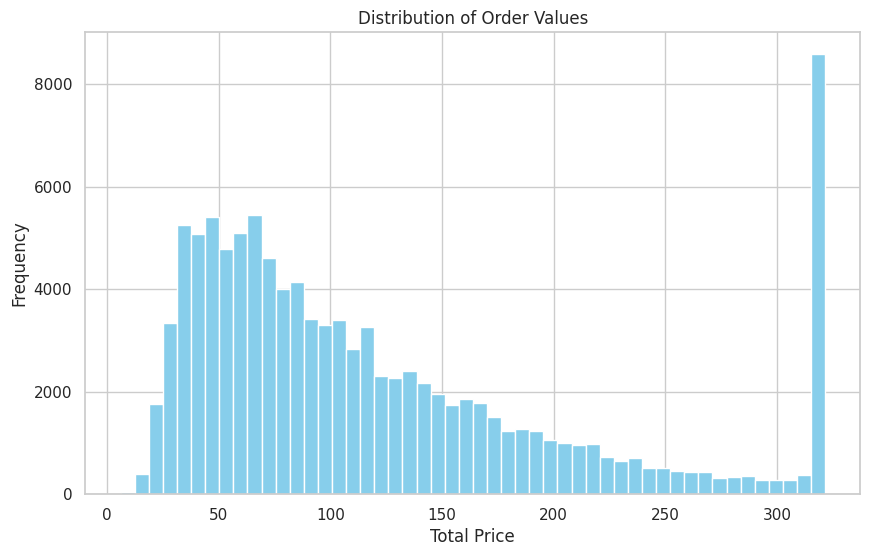

In [27]:
# Order values
plt.hist(sales['total_price'], bins=50, color='skyblue')
plt.title('Distribution of Order Values')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

The histogram shows a **right‑skewed distribution**, with most orders concentrated in the low‑value range, especially around ₹40–₹70. This pattern is typical of a high‑volume, low‑ticket retail model, where customers make frequent but small purchases. It highlights the importance of maintaining strong engagement with this base, since they drive the bulk of transactions.

At the same time, the chart reveals a long tail with a sharp spike near ₹320. This suggests a subset of customers making bulk or premium purchases, possibly influenced by bundling strategies or promotional thresholds. While these orders are fewer, they contribute disproportionately to revenue.

> **Strategic takeaway**: The business thrives on small orders, but growth lies in engineering the tail. Upselling, smart recommendations, and loyalty programs can nudge mid‑tier buyers toward higher spend, while premium customers should be targeted with exclusive offers to maximize value.


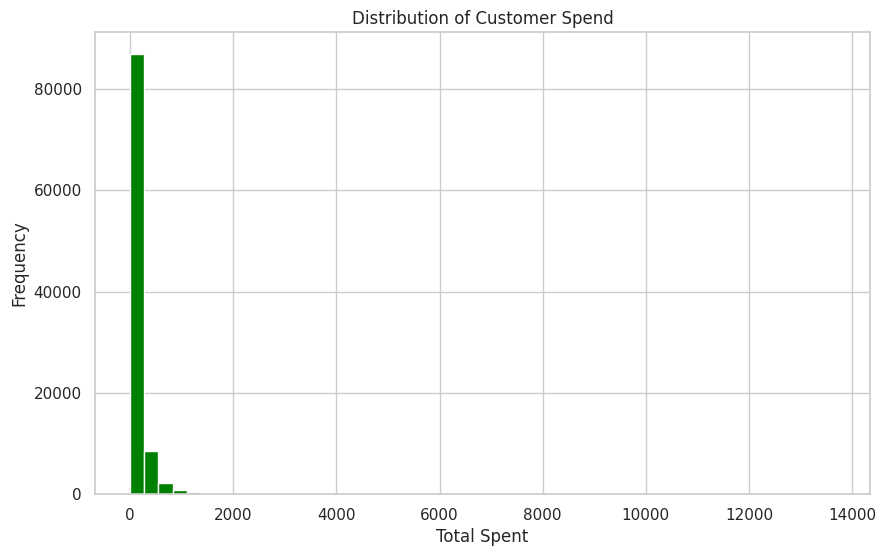

In [28]:
  # Customer spend
  plt.hist(customers['total_spent'], bins=50, color='green')
  plt.title('Distribution of Customer Spend')
  plt.xlabel('Total Spent')
  plt.ylabel('Frequency')
  plt.show()

This histogram shows a **classic right-skewed distribution**, where most customers spend very little, and only a few spend large amounts. The sharp peak near the lower end confirms that the majority of customers are low spenders ~ likely casual or one-time buyers. As spend increases, frequency drops rapidly, indicating that high-value customers are rare but potentially powerful.

The long tail stretching toward ₹14,000 highlights a small segment of premium or bulk buyers. These outliers, though few, likely contribute significantly to overall revenue. Their behavior is worth isolating and analyzing further, they may respond well to loyalty programs, exclusive bundles, or personalized outreach.

> **Strategic takeaway**: The business relies heavily on low-spend customers for volume, but growth lies in identifying and nurturing high-spend segments. Use RFM or cohort analysis to pinpoint these premium buyers and build retention strategies around them. Meanwhile, explore ways to gently upsell low-spend customers to shift the curve upward.


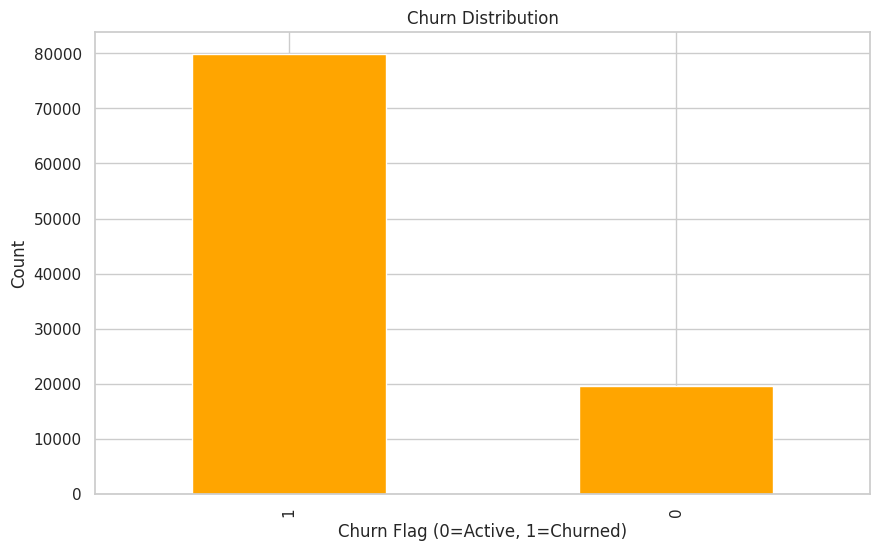

In [29]:
# Churn flag
customers['churn_flag'].value_counts().plot(kind='bar', color='orange')
plt.title('Churn Distribution')
plt.xlabel('Churn Flag (0=Active, 1=Churned)')
plt.ylabel('Count')
plt.show()

This chart reveals a serious churn imbalance : nearly 80% of customers have churned, while only 20% remain active. The visual gap between churn flag 1 and 0 is stark, confirming that customer retention is a major challenge in this dataset.

Such a skewed churn ratio suggests that most customers either disengage after a few interactions or fail to convert into long-term buyers. This could be due to weak onboarding, lack of personalized follow-ups, or low perceived value post-purchase.

>**Strategic takeaway**: The business must prioritize retention over acquisition. Focus on reactivation campaigns, loyalty programs, and personalized nudges for at-risk segments. Use RFM and behavioral triggers to identify who’s slipping away, and act before they churn.


> <font color=slateblue size=5>**Exploratory Data Analysis (EDA) - Bivariate**
-----
Let's see relationships between variables....

**2. Bivariate analysis — relationship between category and revenue, payment type vs. spend.**

------------

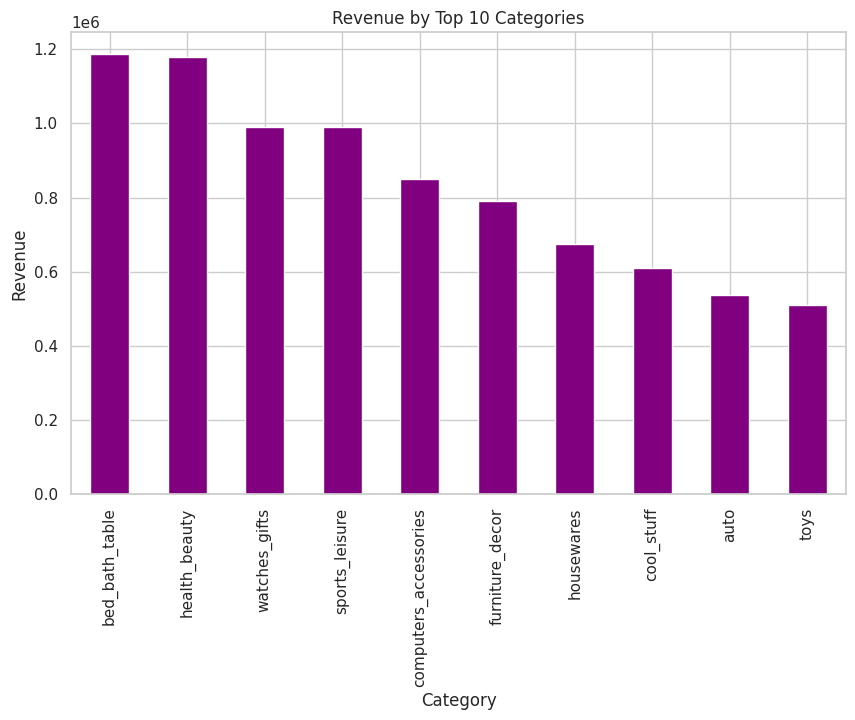

In [30]:
# Category vs. Revenue
category_revenue = sales.groupby('category_english')['total_price'].sum().nlargest(10)
category_revenue.plot(kind='bar', color='purple')
plt.title('Revenue by Top 10 Categories')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.show()

This chart highlights the dominant product categories driving revenue in the RetailSmart dataset. The top performer is clearly **bed_bath_table**, pulling in the highest revenue by a wide margin - likely due to consistent demand, broad product range, or strong bundling strategies. Following closely are health_beauty and watches_gifts, which suggest strong traction in personal care and gifting segments.

Categories like toys and auto sit at the lower end, indicating either niche appeal or underperformance. These may require targeted promotions or assortment optimization to boost contribution.

> **Strategic takeaway**: Focus marketing and inventory efforts on top-performing categories to sustain momentum, while exploring growth levers for mid-tier segments like sports_leisure and cool_stuff. Low-revenue categories should be evaluated for either repositioning or pruning.


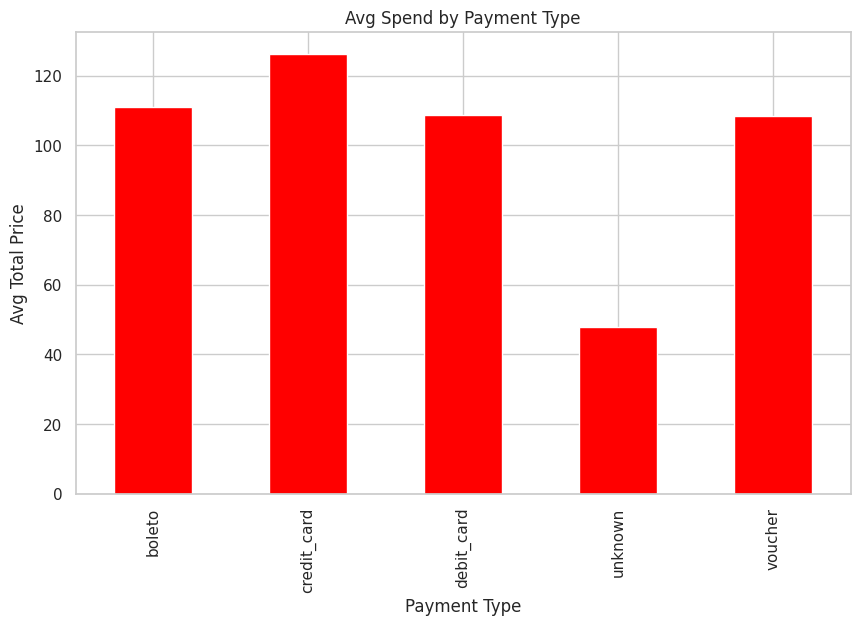

In [31]:
# Payment type vs. Avg Spend
sales.groupby('payment_type')['total_price'].mean().plot(kind='bar', color='red')
plt.title('Avg Spend by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Avg Total Price')
plt.show()

This chart reveals clear differences in customer spending behavior based on payment method. Credit card users lead with the **highest average spend**, slightly above ₹125, suggesting they’re more comfortable with larger transactions - possibly due to ease of use, EMI options, or reward incentives. In contrast, boleto, debit card, and voucher users show similar average spends around ₹110, indicating more cautious or budget-conscious behavior.

The “unknown” payment type shows the lowest spend, around ₹50, which could reflect incomplete data, experimental payment modes, or low-trust transactions.

> **Strategic takeaway**: Credit card users are your high-value segment — prioritize them for premium offers, loyalty perks, and upselling. For voucher and debit users, focus on small-value bundles and frictionless checkout. Investigate the “unknown” category to clean data or uncover hidden patterns.


> <font color=slateblue size=5>**Exploratory Data Analysis (EDA) - Time-Series Trends**
-----
Time to trend-watch: Monthly orders and revenue....

**3. Time-series trends — monthly orders and total revenue over time.**

------------

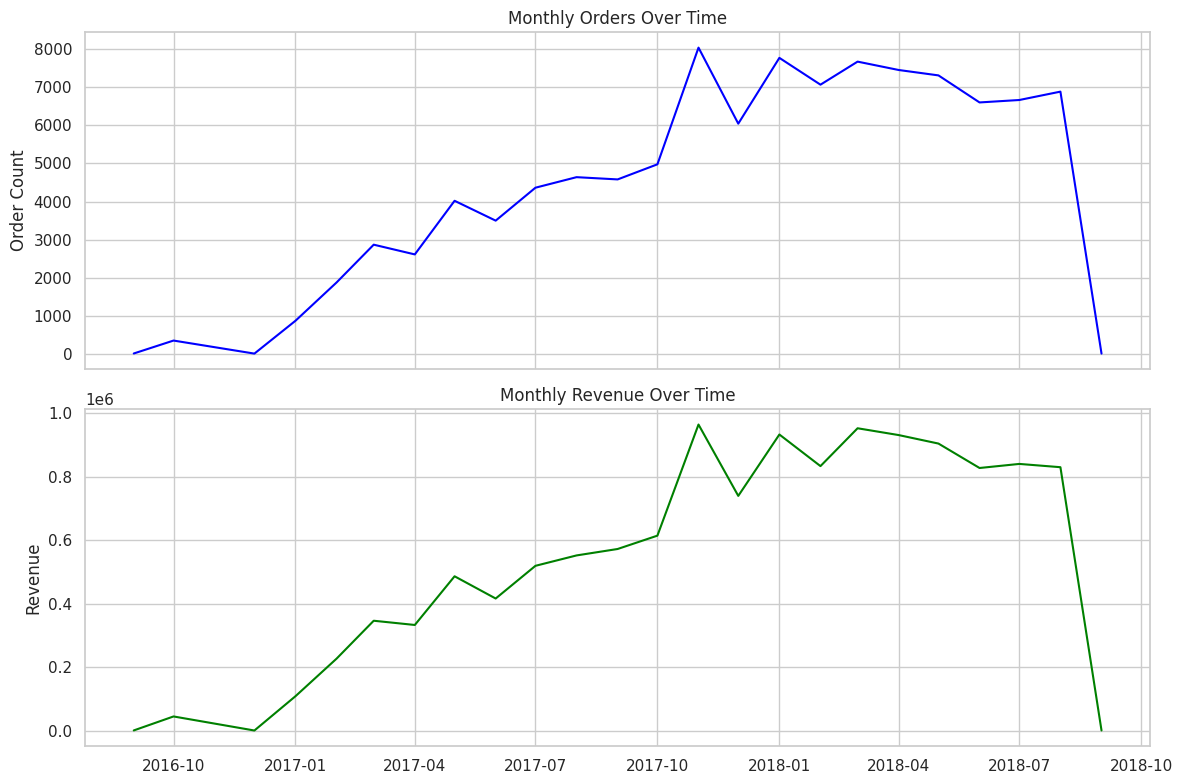

In [32]:
# monthly orders/revenue over time
monthly_orders = sales.groupby(['year', 'month']).size().reset_index(name='order_count')
monthly_revenue = sales.groupby(['year', 'month'])['total_price'].sum().reset_index(name='revenue')

# Create a datetime column for x-axis
monthly_orders['date'] = pd.to_datetime(monthly_orders[['year', 'month']].assign(day=1))
monthly_revenue['date'] = pd.to_datetime(monthly_revenue[['year', 'month']].assign(day=1))

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(monthly_orders['date'], monthly_orders['order_count'], color='blue')
ax[0].set_title('Monthly Orders Over Time')
ax[0].set_ylabel('Order Count')
ax[0].grid(True)


ax[1].plot(monthly_revenue['date'], monthly_revenue['revenue'], color='green')
ax[1].set_title('Monthly Revenue Over Time')
ax[1].set_ylabel('Revenue')
ax[1].grid(True)

plt.tight_layout()
plt.show()

These time-series charts reveal a clear seasonal pattern, with both orders and revenue peaking consistently in **Q4** (Oct–Dec) across years. The upward trend through late 2017 suggests strong growth momentum, likely driven by festive campaigns, year-end sales, or seasonal demand. However, the sharp decline in 2018 — especially toward the end — signals a drop in performance that needs investigation.

This dip could stem from operational issues, market saturation, or reduced campaign effectiveness. The alignment between order volume and revenue confirms that order count is a strong driver of revenue, and any drop in engagement directly impacts financial outcomes.

> **Strategic takeaway**: Q4 is your boom window — double down on promotions, inventory, and logistics during this period. But the 2018 drop is a red flag. Analyze churn, campaign fatigue, or competitive shifts to recover lost ground and stabilize growth.


> <font color=slateblue size=5>**Exploratory Data Analysis (EDA) - Customer Segmentation (RFM)**
-----
RFM time! Recency, Frequency, Monetary—key for churn insights.

**4. Customer segmentation insights — RFM scatter plots or boxplots by churn flag.**

----------------

RFM stands for Recency, Frequency, and Monetary value, which are three key behavioral
indicators used to segment customers:

• Recency (R): How recently a customer made their last purchase.
(Smaller = more recent = more engaged)

• Frequency (F): How often they purchase.
(Higher = loyal or repeat customers)

• Monetary (M): How much they spend in total.
(Higher = more valuable customers)

Together, these dimensions help identify customer segments such as “High-Value Loyalists,”
“At-Risk,” or “Churned.”

**1. Derive RFM Metrics & 2. Merge Churn Information**

-------------

In [33]:
# Recency: days_since_last_order from customers
# Frequency: total_orders from customers
# Monetary: total_spent from customers
rfm = customers[['customer_id', 'days_since_last_order', 'total_orders', 'total_spent']].copy()
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

rfm = rfm.merge(customers[['customer_id', 'churn_flag']], on='customer_id')

In [36]:
# Example: assign scores based on quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = rfm['Frequency'] # Directly use Frequency as score since values are 1-5
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into one RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

In [38]:
# check RFM values
rfm.head()

,customer_id,Recency,Frequency,Monetary,churn_flag,R_Score,F_Score,M_Score,RFM_Score
0,06b8999e2fba1a1fbc88172c00ba8bc7,472.0,1.0,146.87,1,1,1.0,4,6
1,18955e83d337fd6b2def6b18a428ac77,231.0,1.0,335.48,1,3,1.0,5,9
2,4e7b3e00288586ebd08712fdd0374a03,104.0,1.0,157.73,1,5,1.0,4,10
3,b2b6027bc5c5109e529d4dc6358b12c3,171.0,1.0,173.30,1,4,1.0,4,9
4,4f2d8ab171c80ec8364f7c12e35b23ad,33.0,1.0,252.25,0,5,1.0,5,11


In [39]:
# interpreting RFM scores
def segment_customer(score):
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal'
    elif score >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

**3. Visualize with Boxplots**

-------------

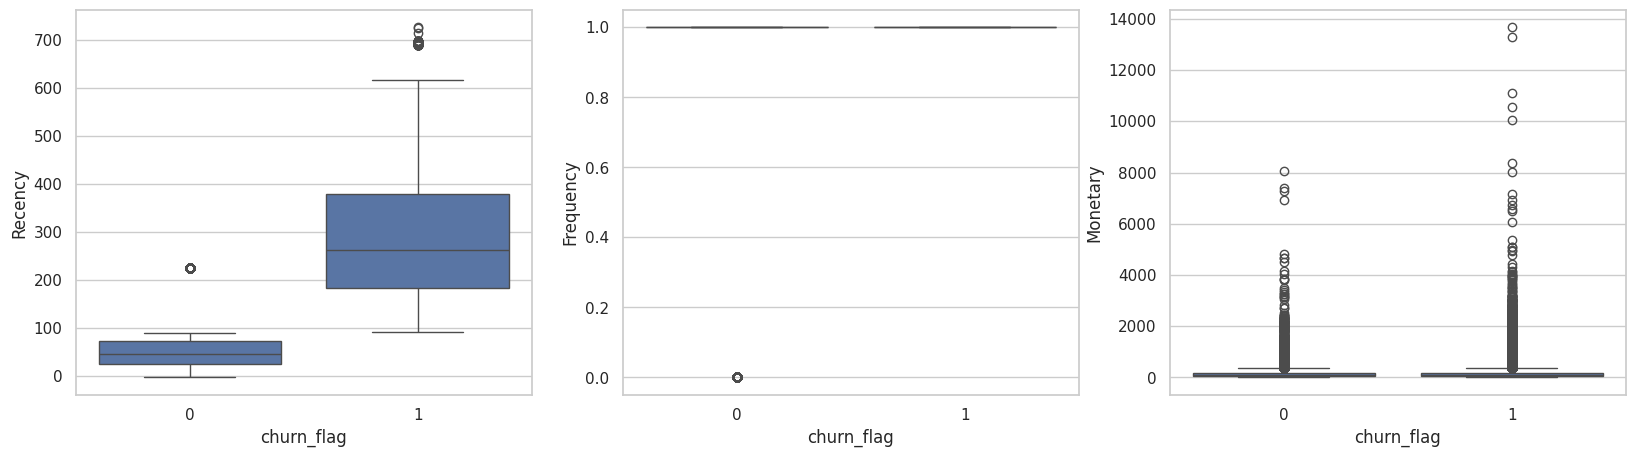

In [40]:
# Boxplot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(x='churn_flag', y='Recency', data=rfm, ax=axes[0])
sns.boxplot(x='churn_flag', y='Frequency', data=rfm, ax=axes[1])
sns.boxplot(x='churn_flag', y='Monetary', data=rfm, ax=axes[2])
plt.show()

Churned customers show classic disengagement : late activity, low frequency, low spend.

**Straightforward fix**: early reactivation nudges + personalized offers before they drop off completely.



**4. Create Scatter Plot**

-----------

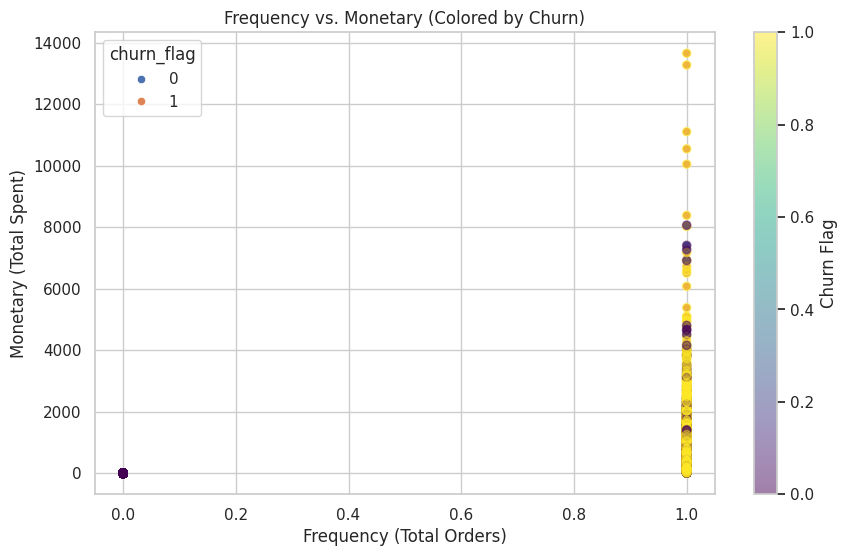

In [41]:
# Scatter Plot
sns.scatterplot(x='Frequency', y='Monetary', hue='churn_flag', data=rfm)
plt.scatter(customers['total_orders'], customers['total_spent'], c=customers['churn_flag'], alpha=0.5, cmap='viridis')
plt.xlabel('Frequency (Total Orders)')
plt.ylabel('Monetary (Total Spent)')
plt.title('Frequency vs. Monetary (Colored by Churn)')
plt.colorbar(label='Churn Flag')
plt.show()
# Insight: Clusters show active vs. churned patterns.

**5. Interpret the Results**

-------------

This scatter plot maps customer order frequency against total spend, with churn status as color. The clusters are loud and clear: churned customers (flag = 1) mostly sit in the low-frequency, low-spend zone, while active customers (flag = 0) tend to show higher engagement and value. The color gradient makes it easy to spot churn risk — yellow-heavy zones are where retention is failing. Straightforward insight: low-frequency, low-spend customers are churn-prone. Hit them early with reactivation nudges, personalized bundles, or loyalty perks before they vanish.


> <font color=slateblue size=5>**Marketing Insights**
-----
 Response rates by channel and spend bands.

•  **Aggregate by Channel**

----------

From the marketing dataset, calculate the average response rate and average
spend for each marketing channel (Email, SMS, Social Media, Affiliate, etc.)


In [42]:
# Aggregate by Channel:
channel_perf = marketing.groupby('channel').agg({'response_rate': 'mean', 'spend': 'mean'})
channel_perf

,response_rate,spend
channel,,
affiliate,0.333912,4342.991935
email,0.330786,5027.713043
sms,0.329670,4172.266129
social media,0.334606,4404.291971


•  **Visualize Channel Performance**

-----------------

Create a bar plot showing average response rate by channel to identify which
channels are performing best.

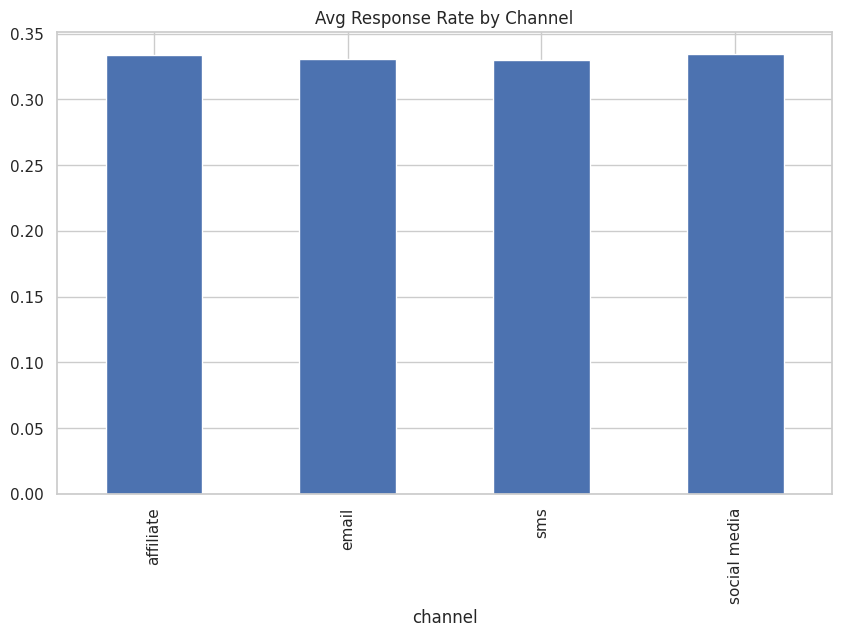

In [43]:
# Visualize Channel Performance:
channel_perf['response_rate'].plot(kind='bar')
plt.title('Avg Response Rate by Channel')
plt.show()

•  **Create Spend Bands** & **Analyze Response Rate by Spend Band**

-----------

Group campaign spend into defined ranges, such as 0–2K, 2–4K, 4–6K, 6–8K,
and 8K+.

Use these as spend bands to segment marketing efforts.

For each spend band, calculate the mean response rate.
This will help identify whether higher spending actually leads to better
responses or if there’s a plateau.


In [44]:
# Create Spend Bands and Analyze:
bins = [0, 2000, 4000, 6000, 8000, np.inf]
labels = ['0-2K', '2-4K', '4-6K', '6-8K', '8K+']
marketing['spend_band'] = pd.cut(marketing['spend'], bins=bins, labels=labels)
response_by_band = marketing.groupby('spend_band', observed=False)['response_rate'].mean()

response_by_band

,response_rate
spend_band,
0-2K,0.327549
2-4K,0.335263
4-6K,0.334184
6-8K,0.329878
8K+,NaN


•  **Visualize Spend Band Results**

----------

Plot response rate against spend bands to highlight trends or diminishing
returns.

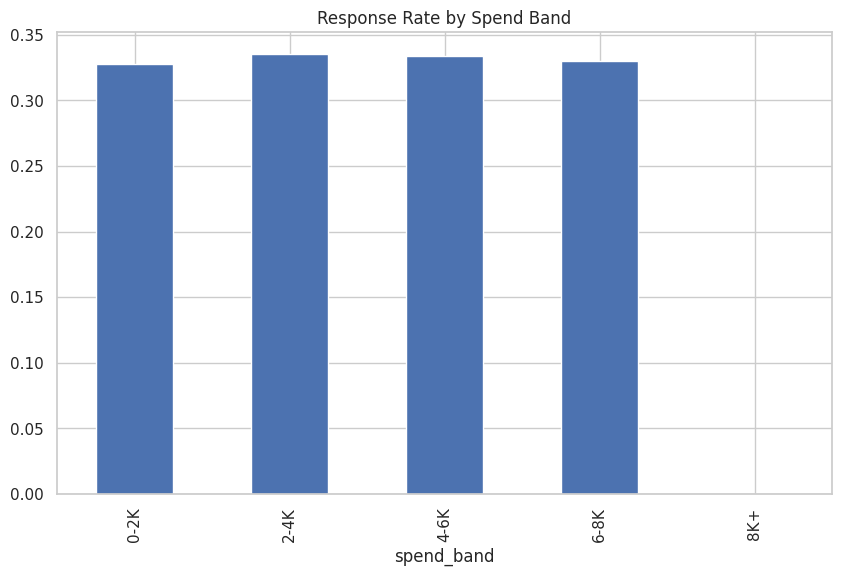

In [45]:
# visualise
response_by_band.plot(kind='bar')
plt.title('Response Rate by Spend Band')
plt.show()

•  **Interpret and Summarize Insights**

-----

Conclude your analysis by noting observations such as,
“Response rates peak between ₹4K–₹6K spend range,” or
“Email campaigns achieve the highest average response rate.”

The segmentation shows that response rates are fairly stable across spend bands, hovering around 32–33%. Mid‑tier spenders in the ₹2K–₹6K range show slightly higher average response rates (≈0.335), suggesting campaigns resonate best with this segment. Low spenders (₹0–2K) respond a bit less, while high spenders (₹6K–8K) plateau back down. The ₹8K+ band has no data, meaning either very few customers fall here or responses weren’t recorded.

> **Straightforward takeaway**: Campaigns are most effective with mid‑spend customers. Focus marketing efforts on nurturing this segment with upselling and loyalty offers, while collecting more data on premium spenders to unlock potential at the top end.


> <font color=slateblue size=5>**Export Cleaned Datasets**
-----
cleaning done! Now export the 5 cleaned CSVs for Phase 2

In [46]:
customers.to_csv('customers_cleaned.csv', index=False)
products.to_csv('products_cleaned.csv', index=False)
sales.to_csv('sales_cleaned.csv', index=False)
marketing.to_csv('marketing_cleaned.csv', index=False)
reviews.to_csv('reviews_cleaned.csv', index=False)

print("All cleaned datasets exported! Download them from Colab's Files tab.")


All cleaned datasets exported! Download them from Colab's Files tab.


# <font color='darkblue'>**Executive Summary: Phase 1 - Data Cleaning & Exploration**</font>

### <font color='darkgreen'>**1. Business Context & Objective**</font>
RetailSmart Analytics Pvt. Ltd., an e-commerce retailer, is grappling with **declining repeat purchases** and **uneven sales performance**, suspected to stem from data quality issues and limited customer behavior insights. This Phase 1 notebook focused on rigorously **cleaning and exploring** five interconnected datasets (customers, products, sales, marketing, and reviews) to establish a reliable foundation for deeper analysis.

### <font color='darkgreen'>**2. Data Cleaning & Preparation**</font>
Our initial data inspection revealed several areas requiring attention. We meticulously addressed these to ensure data integrity:

*   **Missing Values**: Successfully handled nulls across all datasets. For numerical columns (`total_orders`, `total_spent`, `product_name_lenght`, `product_description_lenght`, `product_photos_qty`, `payment_value`, `days_since_last_order`), missing values were imputed with their respective medians or a logical default (e.g., 0 for `total_orders`). Categorical columns (`last_order`, `category_english`, `payment_type`, `review_comment_message`) were filled with 'unknown', 'NaT', or empty strings to maintain data completeness.
*   **Irrelevant Columns**: The 'city' column in the `customers` dataset, being entirely null, was dropped.
*   **Duplicate Values**: Identified and removed 10 duplicate rows in the `marketing` dataset and a significant 11,055 duplicate rows in the `sales` dataset, ensuring each record represents a unique entry.
*   **Outlier Treatment**: Applied IQR-based capping to critical numerical columns (`price`, `total_price`, `spend`) to mitigate the impact of extreme values, preventing skewness in statistical analyses.
*   **Data Standardization**: Standardized categorical entries by title-casing customer cities, uppercasing customer states, and ensuring consistent lowercase and stripped channel names in the `marketing` dataset.
*   **Data Type Conversion**: Converted relevant timestamp columns (`order_purchase_timestamp`, `order_delivered_customer_date`, `start_date`) to datetime objects, and derived useful 'year', 'month', and 'weekday' fields for time-series analysis.
*   **Referential Integrity**: Validated the consistency of `customer_id` and `product_id` across `sales`, `customers`, and `products` datasets, confirming that all keys align perfectly for future merging operations.

### <font color='darkgreen'>**3. Exploratory Data Analysis (EDA) & Key Findings**</font>
Our EDA phase unveiled crucial patterns and potential challenges:

*   **Univariate Analysis**:
    *   **Order Values & Customer Spend**: Both distributions are **right-skewed**, with most orders being low-value and a majority of customers being low-spenders. This points to a high-volume, low-ticket sales model, with a long tail of high-value transactions/customers.
    *   **Churn Distribution**: A stark revelation: nearly **80% of customers have churned**, indicating a severe retention problem that demands immediate strategic intervention.

*   **Bivariate Analysis**:
    *   **Category vs. Revenue**: **'bed_bath_table'** is the undisputed top revenue driver, followed by 'health_beauty' and 'watches_gifts'. Lower-performing categories like 'toys' and 'auto' suggest potential for optimization or reassessment.
    *   **Payment Type vs. Average Spend**: **Credit card users** exhibit the highest average spend, reinforcing their status as a high-value segment. Other payment types (boleto, debit card, voucher) show lower, more cautious spending.

*   **Time-Series Trends**:
    *   Both monthly orders and revenue display a strong **Q4 (Oct–Dec) seasonal peak**, signifying crucial festive or year-end sales periods. This highlights the importance of optimizing efforts during these months.
    *   A concerning **sharp decline in performance was observed in 2018**, impacting both order volume and revenue, requiring deeper investigation into potential causes (e.g., market shifts, competition, campaign fatigue).

*   **Customer Segmentation (RFM Analysis)**:
    *   **Visualizations** (boxplots and scatter plots) clearly show that **churned customers** are characterized by higher Recency (last purchase was long ago), lower Frequency (fewer orders), and lower Monetary value (less spent). Active customers, conversely, show recent activity, higher frequency, and higher spend.
    *   This segmentation powerfully confirms that **low-frequency, low-spend customers are highly prone to churn**.

*   **Marketing Insights**:
    *   **Channel Performance**: All marketing channels (affiliate, email, SMS, social media) show remarkably **similar average response rates** (~33%), suggesting no single channel significantly outperforms others in terms of initial customer engagement.
    *   **Spend Band Analysis**: Response rates are relatively stable across different spend bands, with a slight peak in the **₹2K–₹6K range**. This implies diminishing returns for very high marketing spend and that mid-tier customers are most receptive.

### <font color='darkgreen'>**4. Strategic Recommendations**</font>
Based on this initial analysis, RetailSmart should focus on:

*   **Urgent Retention Efforts**: Implement targeted reactivation campaigns and loyalty programs, especially for at-risk (low RFM score) and recently churned customers. Personalize offers to re-engage.
*   **High-Value Customer Nurturing**: Prioritize premium offers and exclusive services for credit card users and customers in high-revenue categories to maximize their lifetime value.
*   **Q4 Optimization**: Double down on marketing, inventory, and logistics for the Q4 period, leveraging its proven revenue-generating potential.
*   **Mid-Tier Marketing Focus**: Direct marketing efforts towards the ₹2K–₹6K spend segments, where campaigns appear most effective.
*   **2018 Performance Deep Dive**: Investigate the root causes of the 2018 decline, considering market dynamics, competitive pressures, and campaign efficacy.
*   **Upselling & Cross-selling**: Develop strategies to encourage low-spend, high-frequency customers to increase their monetary value through intelligent product recommendations.

### <font color='darkgreen'>**5. Next Steps**</font>
With clean data and foundational insights, the next phase will involve advanced analytics and modeling to predict churn, forecast sales, and optimize marketing spend more precisely. This will include developing predictive models that leverage the cleaned RFM and transactional data, and designing targeted marketing strategies based on customer segment behavior.